## Setup

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from statsforecast.core import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast.models import Naive, SeasonalNaive
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

GOLD_PATH = '/home/lucas-nunes/workspace/Postech/challenges/2_ibov/data/gold'

# GOLD_PATH = "./"

# GOLD_PATH = r./"

PERIOD_SEAZONAL_NAIVE_WEEKLY = 7
PERIOD_SEAZONAL_NAIVE_MONTHLY = 30

MIN_THRESHOLD_VALID = 0.70

SPLIT_TEST_DATE = datetime.date(2024, 12, 31)
SPLIT_TEST_DATE_STR = SPLIT_TEST_DATE.strftime('%Y-%m-%d')
TOMORROW_DATE = datetime.datetime.now().date() + datetime.timedelta(days=1)
PREDICTION_DAYS = (TOMORROW_DATE-SPLIT_TEST_DATE).days

LIST_COLUMNS_DF_FILTER = ['data', 'ultimo']

## Leitura dos dados

In [164]:
df = pd.read_parquet(f'{GOLD_PATH}/gold.parquet')
list_value_columns = df.columns.to_list()
list_value_columns.remove('data')
list_value_columns.remove('ibov')
list_value_columns.remove('ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov')
list_value_columns

['prata',
 'us30',
 'ouro',
 'spx',
 'ndx',
 'petroleo',
 'vix',
 'eur_brl',
 'usd_brl',
 'ibrx100',
 'BBSA3',
 'CPLE6',
 'ITUB4',
 'VALE3',
 'PETR3',
 'ELET3',
 'ibrx50',
 'FTXIN9',
 'RENT3',
 'us500',
 'SLCE3',
 'cobre',
 'FLRY3',
 'bitcoin',
 'ferro',
 'MGLU3',
 'STOXX50E',
 'ethereum',
 'CRFB3',
 'ibov_futuro',
 'ibov']

## Correlações

In [165]:
df_2k = df.where(df['data'] > datetime.date(2000, 1, 1)).dropna(how='all')

In [166]:
correlation_matrix = df[list_value_columns].corr()
correlation_matrix_only_ibov = df[list_value_columns].corr()[['ibov']].sort_values(by='ibov')
correlation_matrix_2k = df_2k[list_value_columns].corr()

In [167]:
list_index_within_threshold = [key for key, value in correlation_matrix['ibov'].to_dict().items() if value > MIN_THRESHOLD_VALID]

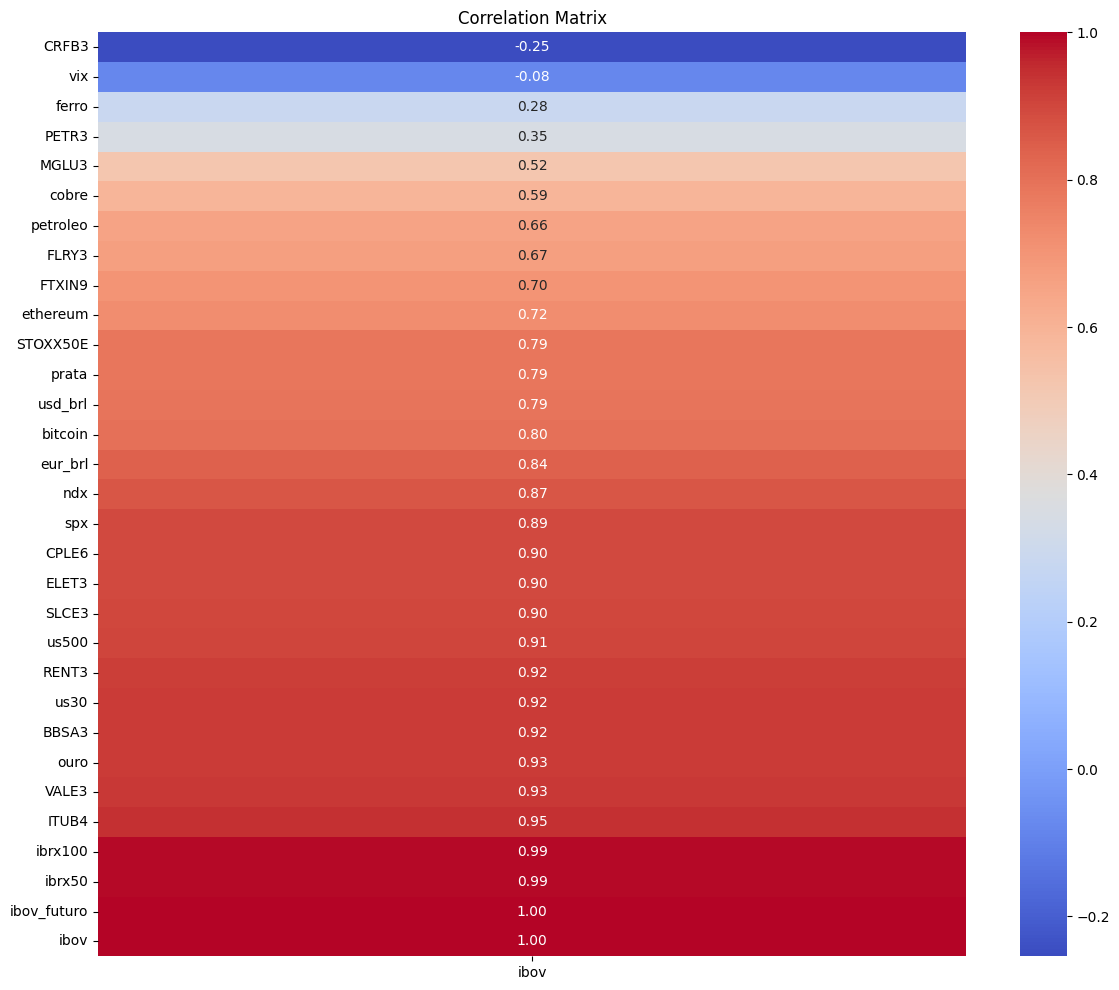

In [168]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_only_ibov, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

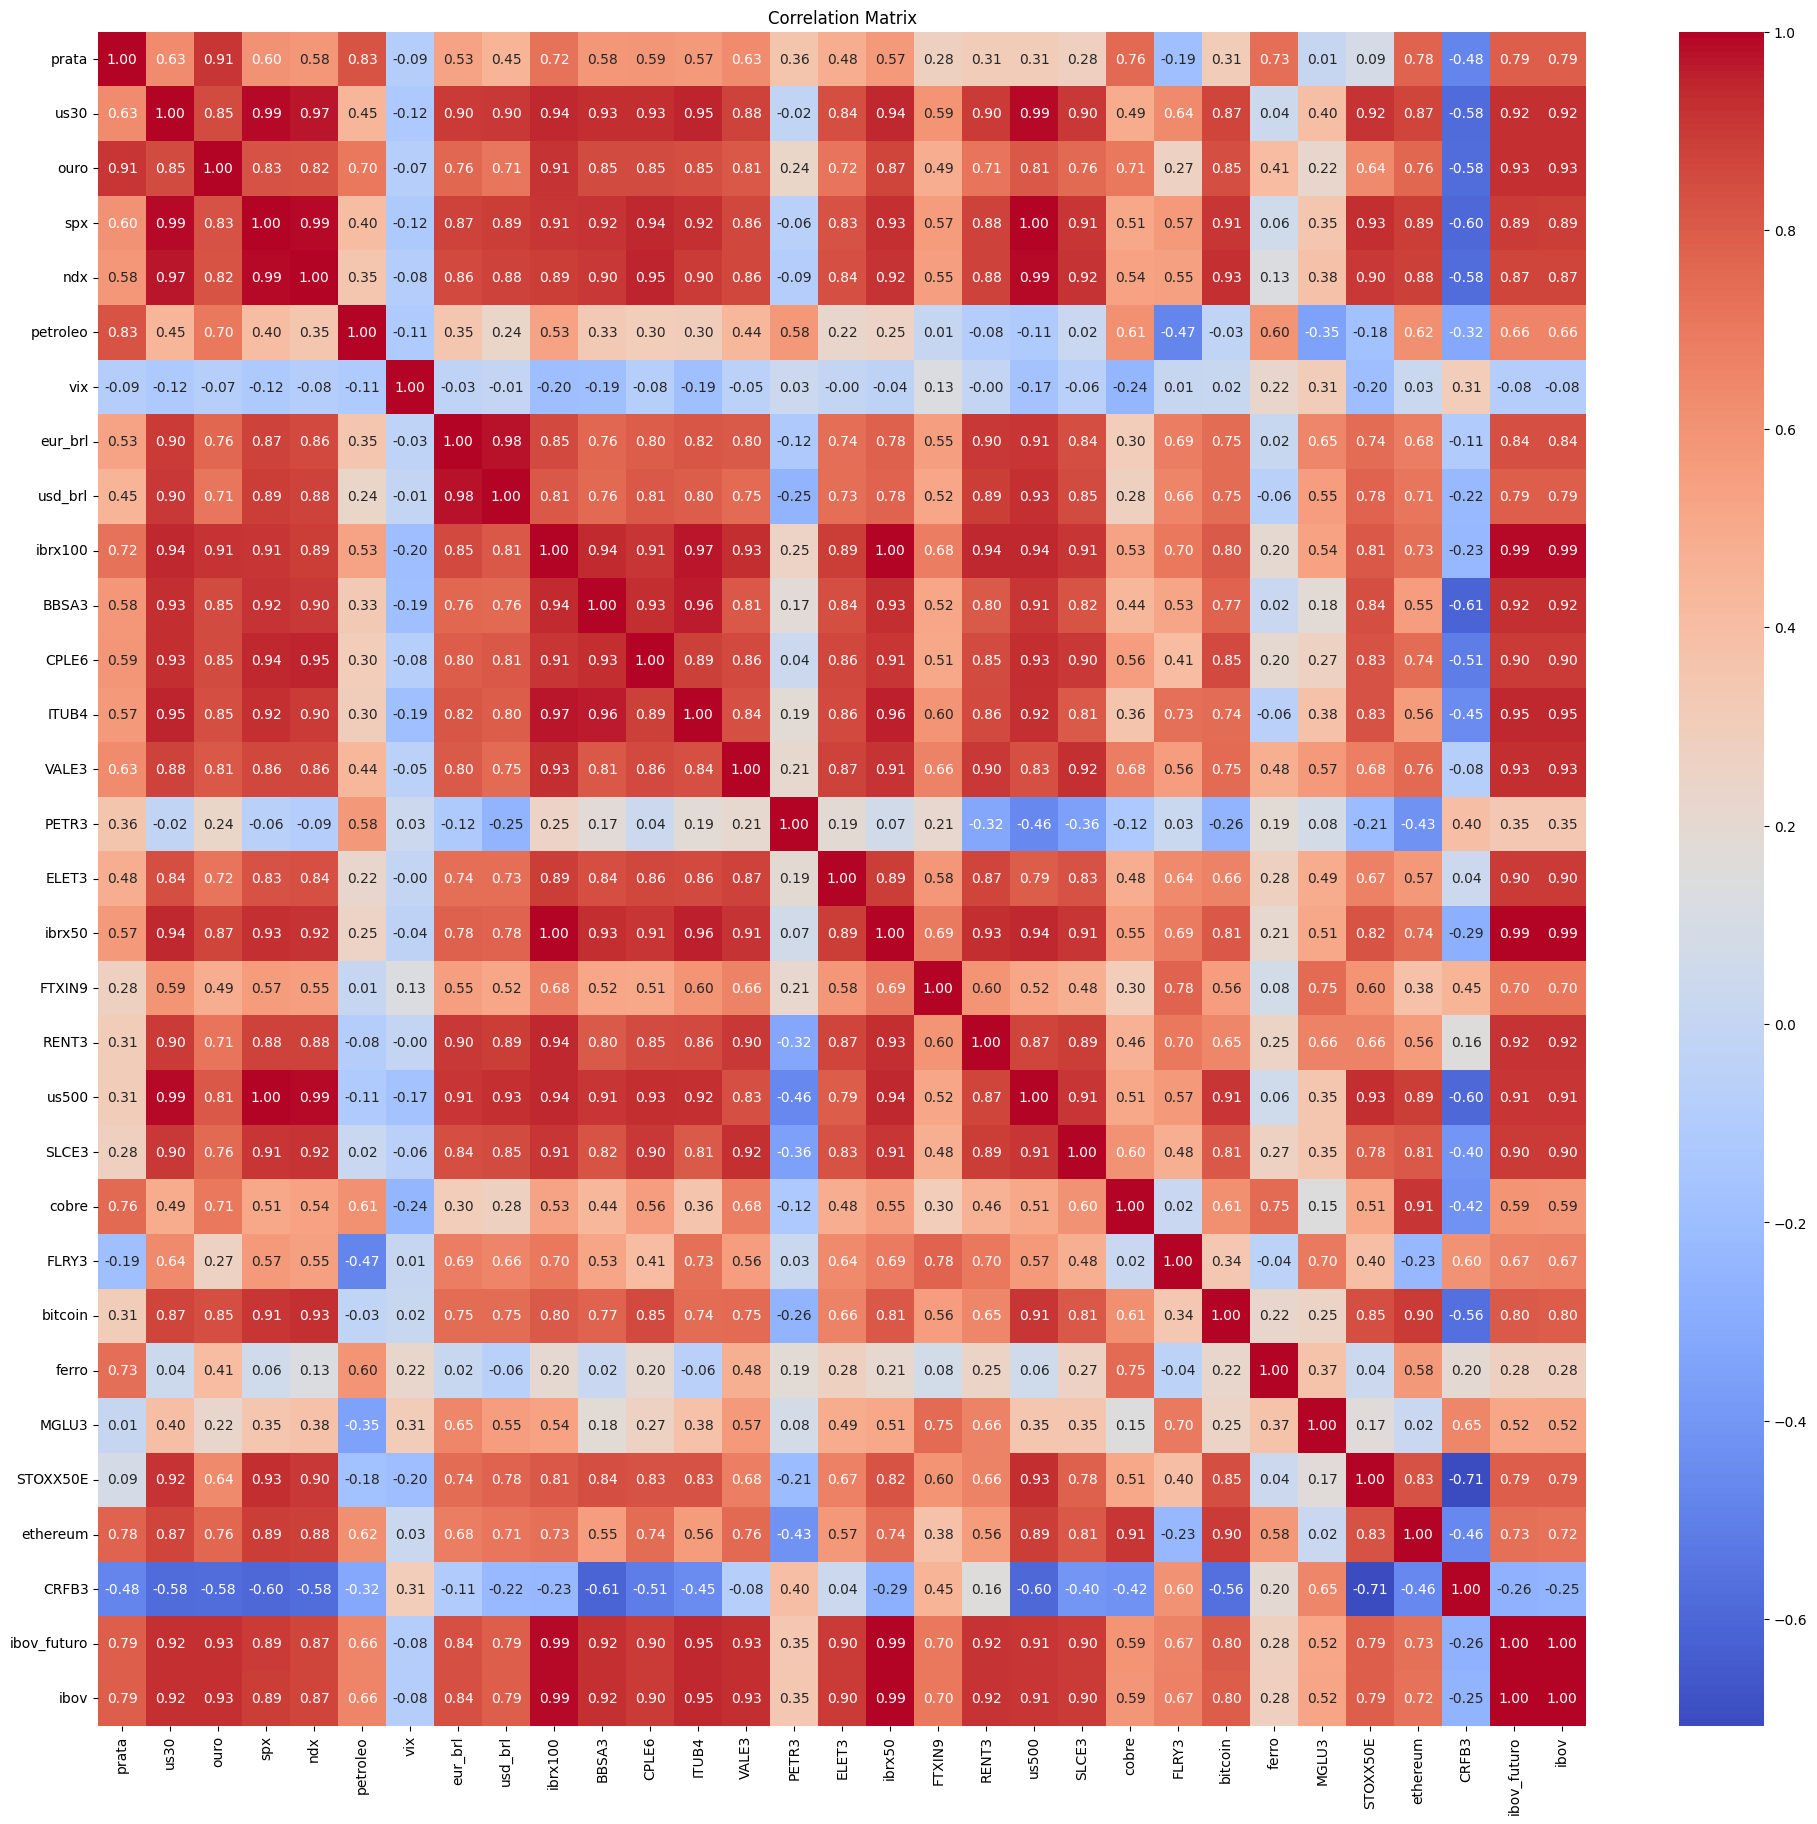

In [169]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

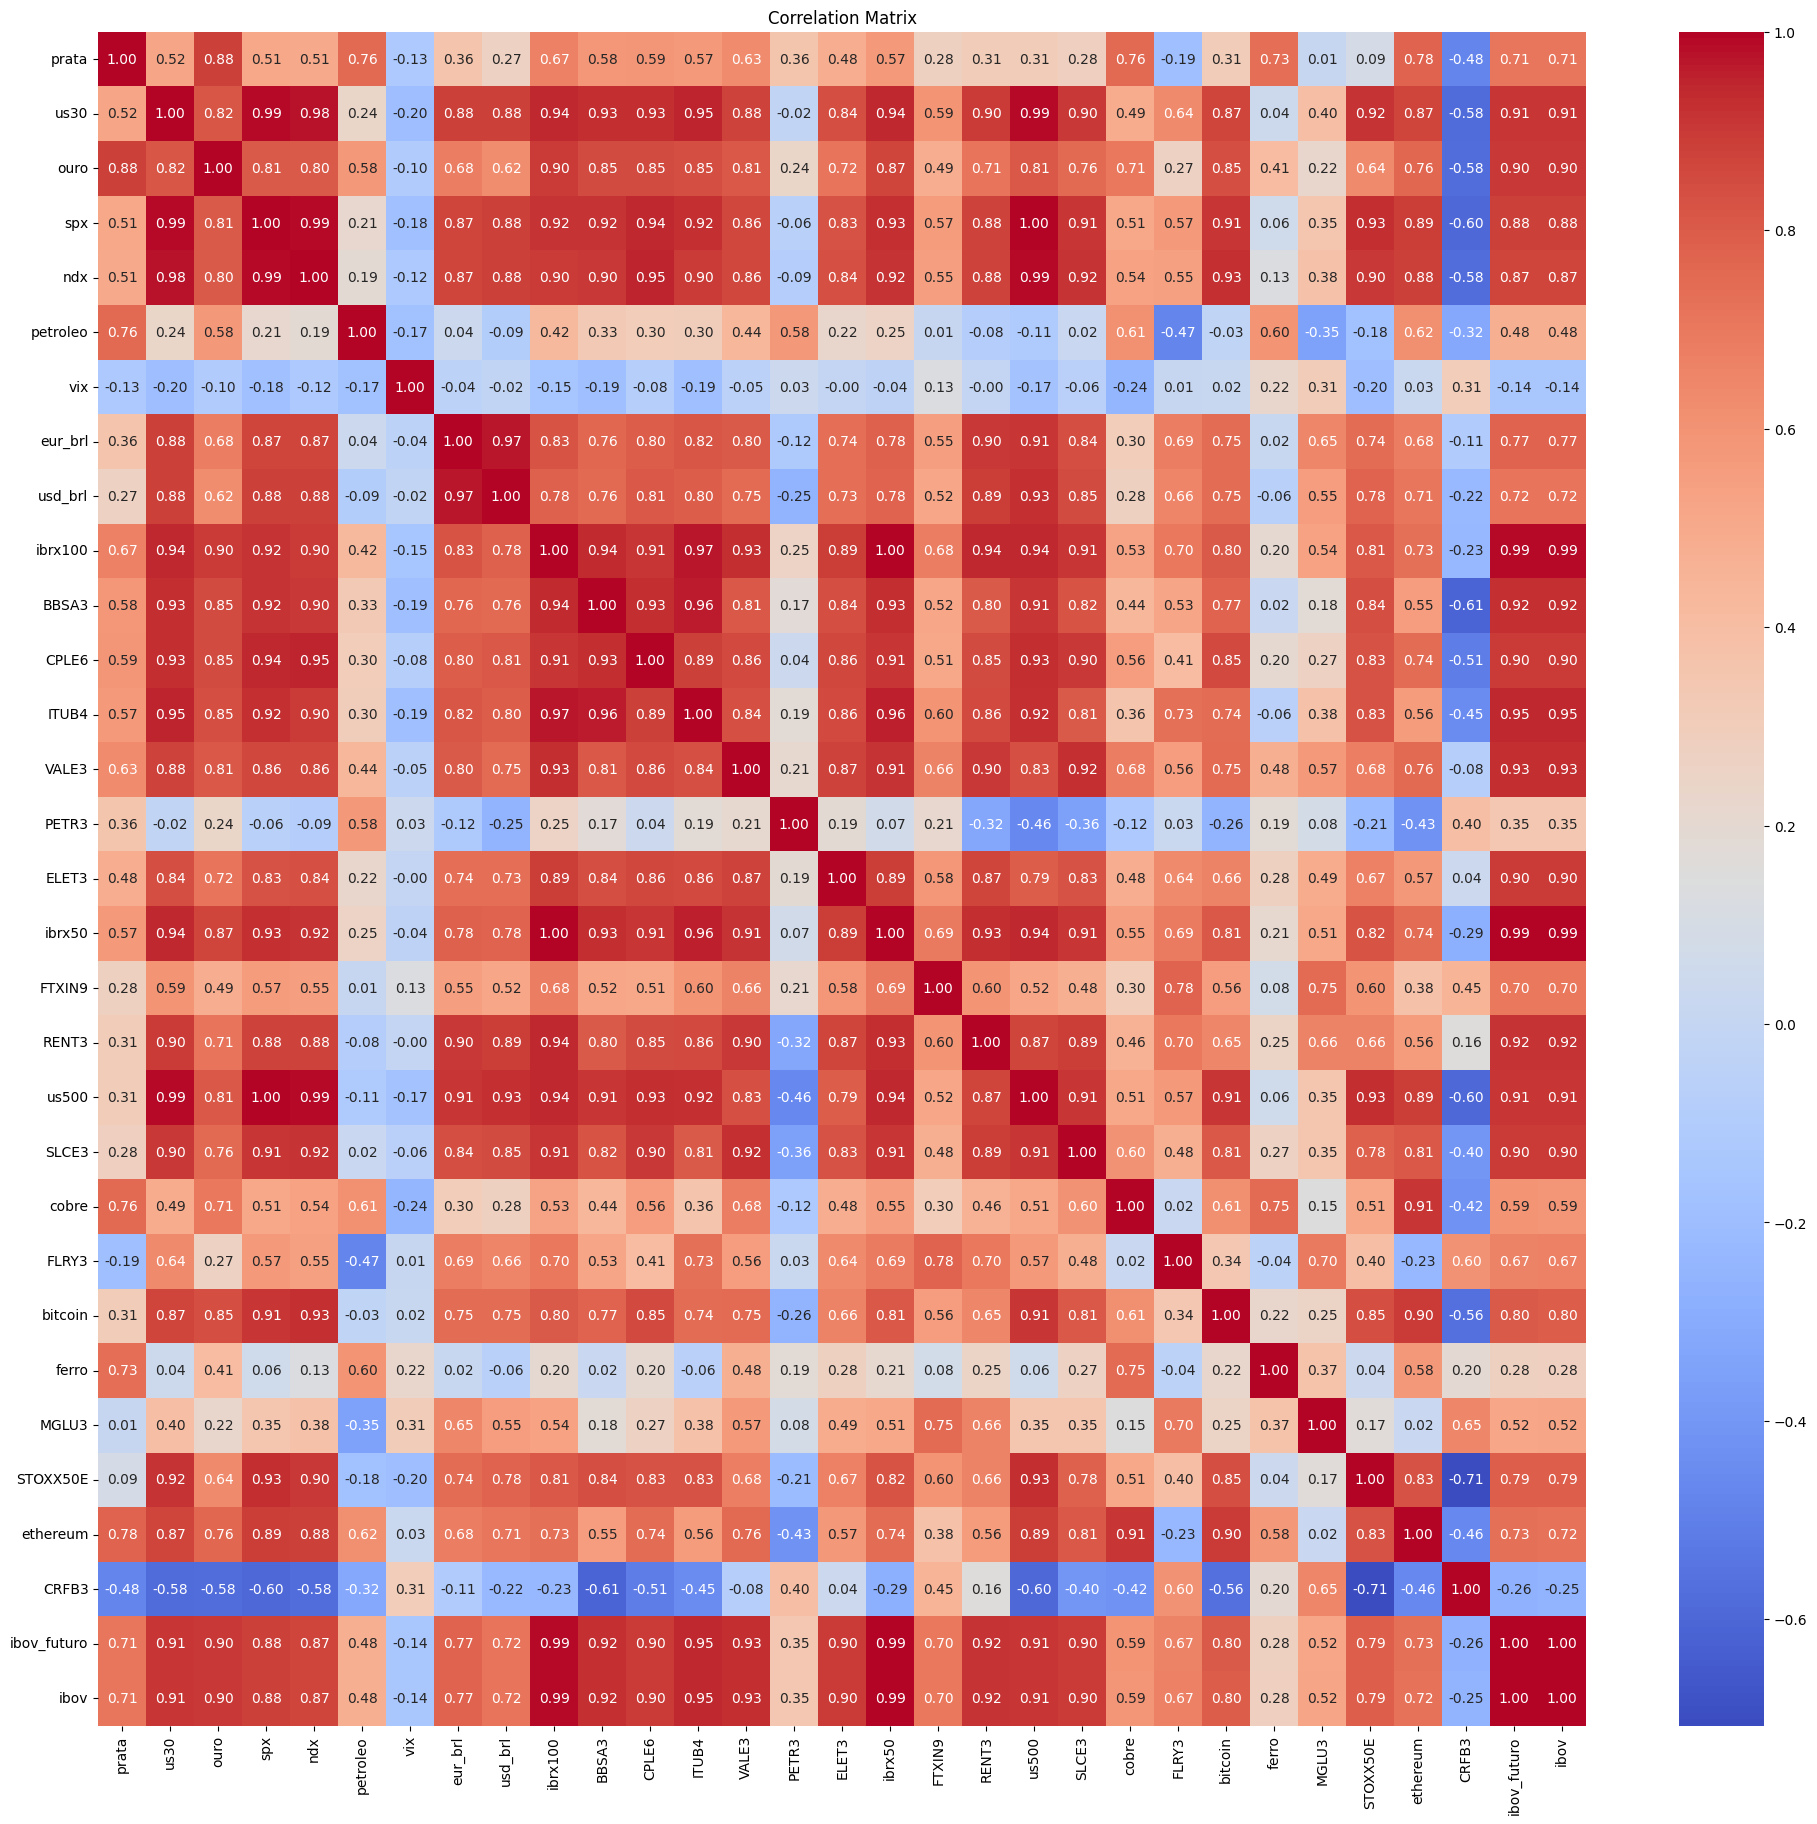

In [170]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix_2k, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Timeseries Forecast Model

## Análise exploratória do dados

### Preparação dos dados

In [171]:
df = df[['data', 'ibov']]

df.index = pd.to_datetime(df.data, format = '%m-%d-%Y')

df.drop('data', inplace=True, axis=1)

### Ajuste temporal dos dados

In [172]:
df = df[df.index >= '1994-01-01']

### Visualização dos dados históricos do Índice Ibovespa

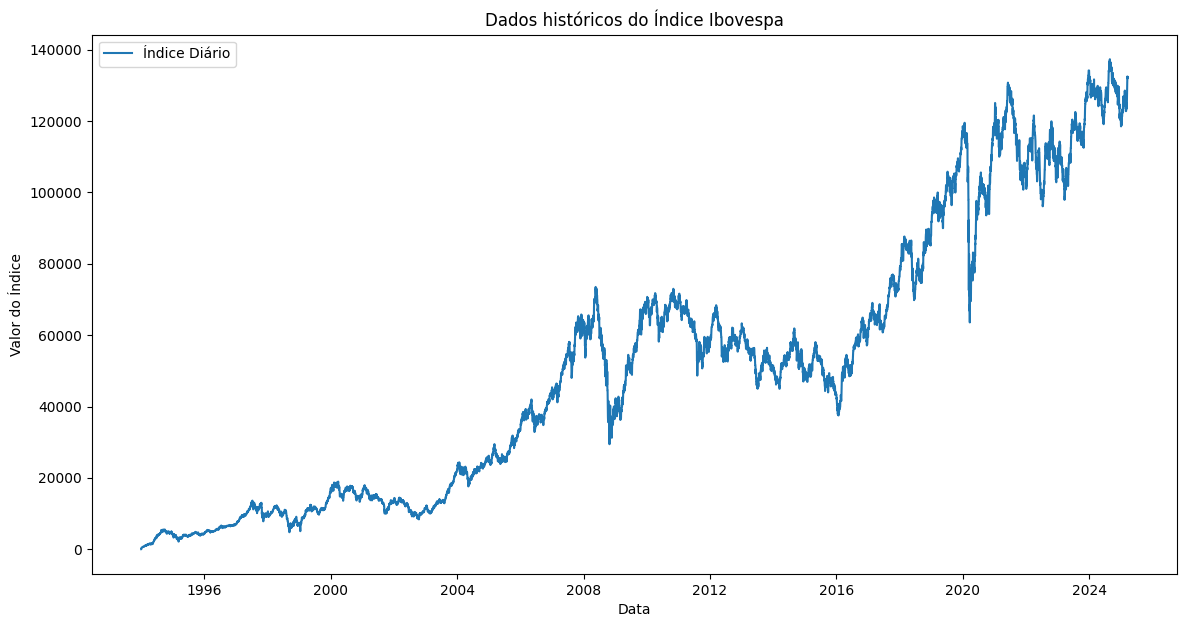

In [173]:
# Plot dos dados originais
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["ibov"], label="Índice Diário")
plt.title("Dados históricos do Índice Ibovespa")
plt.xlabel("Data")
plt.ylabel("Valor do Índice")
plt.legend()
plt.show()

### Decomposição da série temporal

<Axes: xlabel='data'>

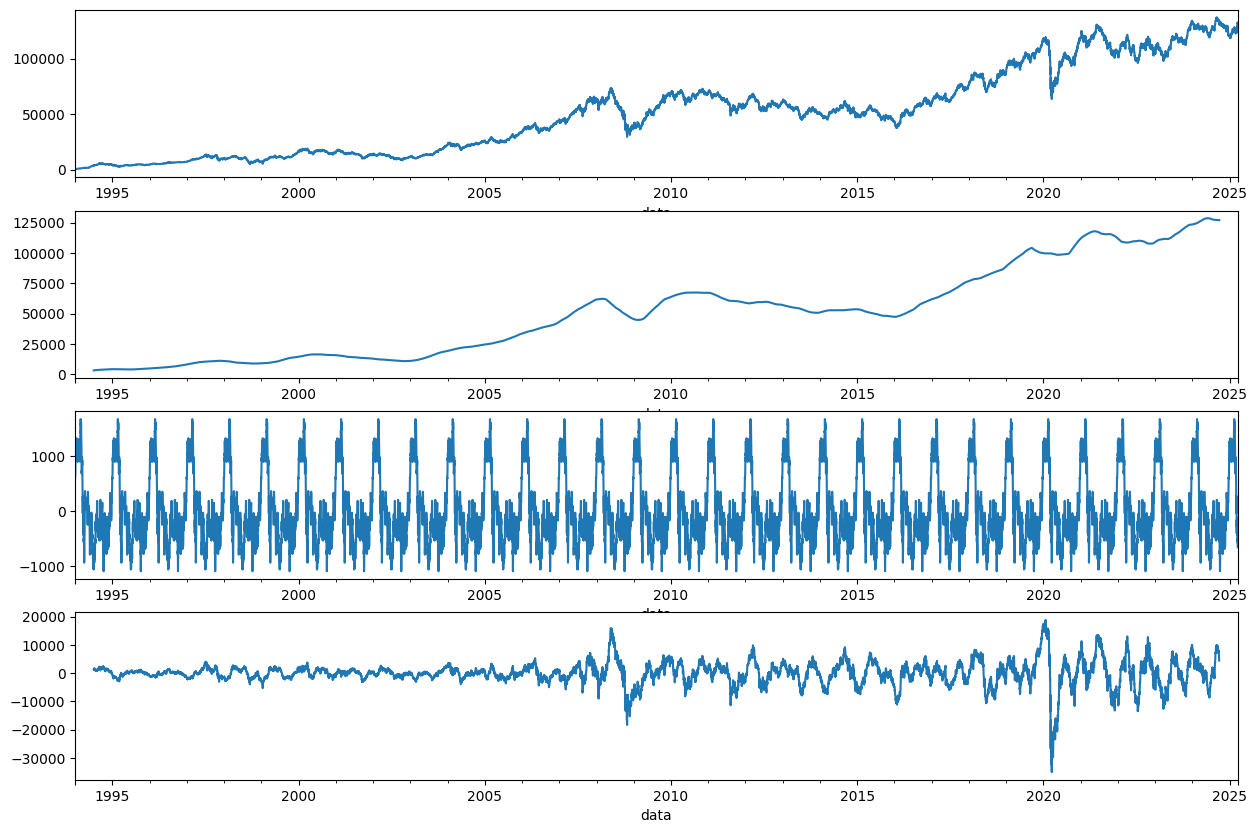

In [174]:
resultados = seasonal_decompose(df, period=365)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

## Teste de Estacionalidade

### Teste de Dickey-Fuller Aumentado (ADF)

In [175]:
# Teste ADF
resultado_adf = adfuller(df["ibov"].dropna())
print(f"Estatística ADF: {resultado_adf[0]}")
print(f"Valor-p: {100*resultado_adf[1]:.2f}%")

# Interpretação
if resultado_adf[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: -0.450593546346911
Valor-p: 90.13%
A série não é estacionária.


## Identificação dos parâmetros do modelo

### Identifica ACF e PACF

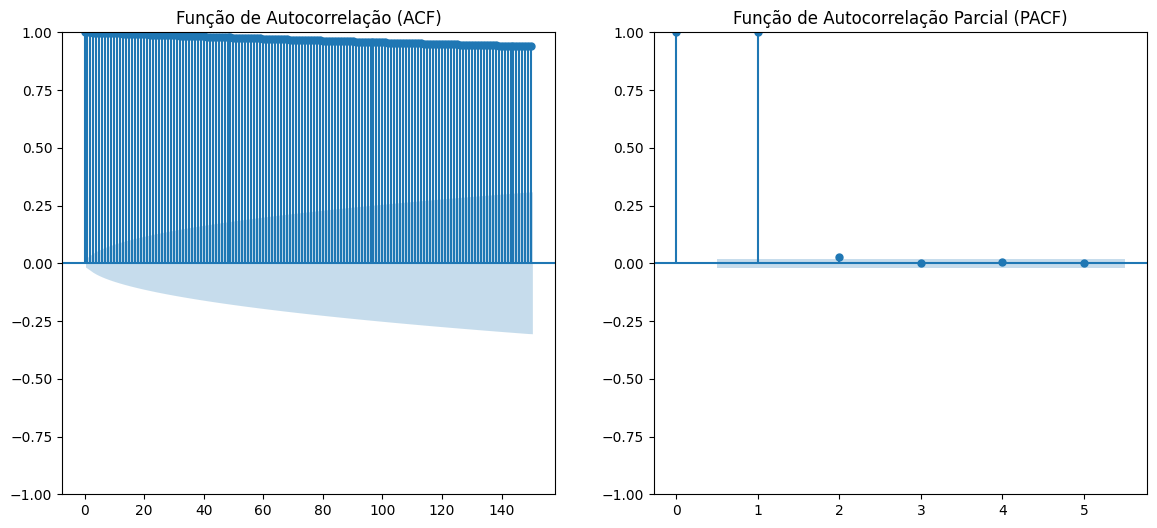

In [178]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(df["ibov"].dropna(), ax=plt.gca(), lags=150)
plt.title("Função de Autocorrelação (ACF)")
plt.subplot(122)
plot_pacf(df["ibov"].dropna(), ax=plt.gca(), lags=5)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

##### Não foi possível identificar valores consistentes pelos testes ACF e PACF, logo para os modelos ARIMA e SARIMA foram testados outros valores que mantiveram um bom resultado de precisão.

## Splitando os dados de Teste e Treino

In [180]:
# Definição dos dados de teste e treino
df_training = df.loc[:SPLIT_TEST_DATE_STR]
df_test = df.loc[SPLIT_TEST_DATE_STR:].iloc[1:]

## Função para calcular o WMAPE

In [181]:
# Função para calcular WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(y_true) + 1e-10)

## Naive

### Ajuste e previsão do modelo

WMAPE: 3.61%


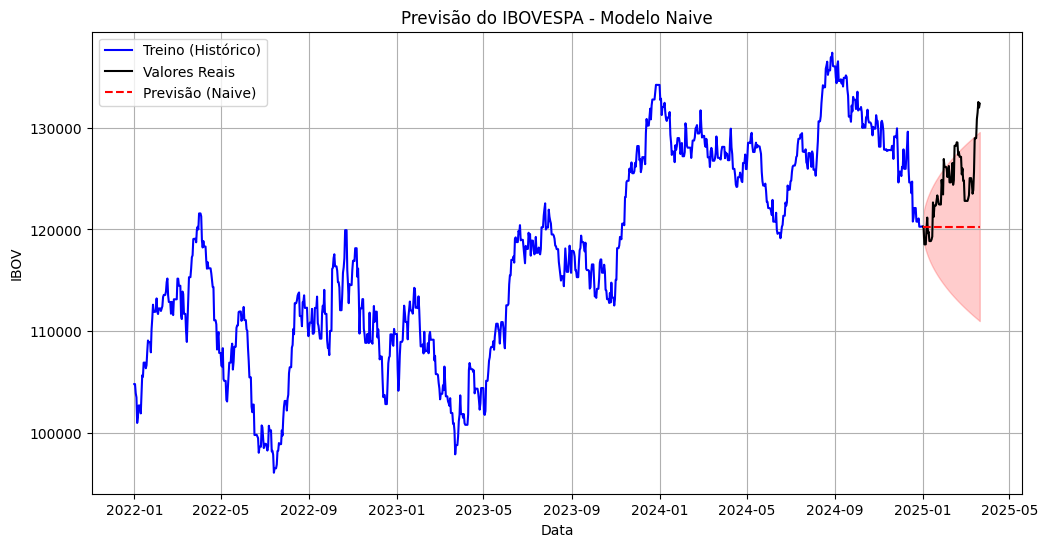

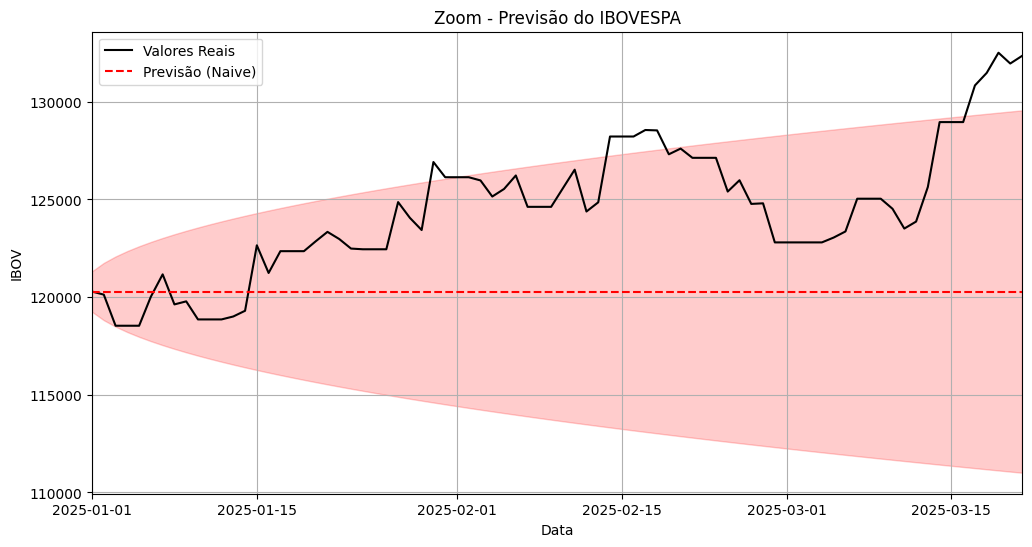

In [182]:
# Estruturação para modelagem
treino_naive = df_training.rename(columns={'ibov': 'y'})
treino_naive['ds'] = treino_naive.index
treino_naive.reset_index(drop=True)
treino_naive['unique_id'] = 'IBOV'
valid_naive = df_test.rename(columns={'ibov': 'y'})
valid_naive['ds'] = valid_naive.index
valid_naive.reset_index(drop=True)

# Definição do horizonte de previsão
h = valid_naive.shape[0]

# Configuração e treinamento do modelo
model_naive = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model_naive.fit(treino_naive[['unique_id', 'ds', 'y']])

# Fazer previsão para o mesmo período da validação
forecast_df_naive = model_naive.predict(h=h, level=[PREDICTION_DAYS])
forecast_df_naive['ds'] = pd.to_datetime(forecast_df_naive.ds, format = '%m-%d-%Y')

# Merge com valores reais
forecast_df_naive = forecast_df_naive.merge(valid_naive, on='ds', how='left')
forecast_df_naive.dropna(subset=['y', 'Naive'], inplace=True)

forecast_df_naive['diff_perc'] = abs(forecast_df_naive['y'] - forecast_df_naive['Naive'])/forecast_df_naive['y']
forecast_df_naive['precision'] = 1 - forecast_df_naive['diff_perc']

# Cálculo do erro WMAPE
if not forecast_df_naive.empty and forecast_df_naive['y'].sum() > 0:
    erro_wmape = wmape(forecast_df_naive['y'].values, forecast_df_naive['Naive'].values)
    print(f'WMAPE: {erro_wmape:.2%}')
else:
    print("Erro: Não há valores suficientes para calcular WMAPE.")

# Função para plotar os resultados
def plot_forecast_naive(treino, valid, forecast_df, title="Previsão do IBOVESPA - Modelo Naive"):
    treino_filtered = treino[treino['ds'] >= '2022-01-01']
    valid_filtered = valid[valid['ds'] >= '2022-01-01']
    forecast_filtered = forecast_df[forecast_df['ds'] >= '2022-01-01']

    plt.figure(figsize=(12, 6))
    plt.plot(treino_filtered['ds'], treino_filtered['y'], label="Treino (Histórico)", color="blue")
    plt.plot(valid_filtered['ds'], valid_filtered['y'], label="Valores Reais", color="black")
    plt.plot(forecast_filtered['ds'], forecast_filtered['Naive'], label="Previsão (Naive)", color="red", linestyle="dashed")

    plt.fill_between(forecast_filtered['ds'], 
                     forecast_filtered[f'Naive-lo-{PREDICTION_DAYS}'], 
                     forecast_filtered[f'Naive-hi-{PREDICTION_DAYS}'], 
                     color='red', alpha=0.2)

    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    # Adicionar zoom na parte final
    plt.figure(figsize=(12, 6))
    zoom_start = valid['ds'].min()
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['Naive'], label="Previsão (Naive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df[f'Naive-lo-{PREDICTION_DAYS}'], forecast_df[f'Naive-hi-{PREDICTION_DAYS}'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title("Zoom - Previsão do IBOVESPA")
    plt.legend()
    plt.grid()
    plt.xlim(zoom_start, forecast_df['ds'].max())
    plt.show()

# Plot dos resultados
plot_forecast_naive(treino_naive, valid_naive, forecast_df_naive)

## Seasonal Naive

### Funções Auxiliares

In [183]:
def seazonal_naive(df_training, df_test, period):
  
  # Estruturação para modelagem
  treino = df_training.rename(columns={'ibov': 'y'})
  treino['ds'] = treino.index
  treino.reset_index(drop=True)
  treino['unique_id'] = 'IBOV'
  valid = df_test.rename(columns={'ibov': 'y'})
  valid['ds'] = valid.index
  valid.reset_index(drop=True)

  h = valid.shape[0]

  # Configuração e treinamento do modelo
  model_s = StatsForecast(models=[SeasonalNaive(season_length=period)], freq='D', n_jobs=-1) # Considerando sazonalidade de mensal, caso a gente queira mudar (semanal (7) / trimestral (90) / semestral (180) / anual (365), alterar aqui)
  model_s.fit(treino[['unique_id', 'ds', 'y']])

  # Fazer previsão para o mesmo período da validação
  forecast_df = model_s.predict(h=h, level=[PREDICTION_DAYS])
  forecast_df['ds'] = pd.to_datetime(forecast_df.ds, format = '%m-%d-%Y')

  # Merge com valores reais
  forecast_df = forecast_df.merge(valid, on='ds', how='left')
  forecast_df.dropna(subset=['y', 'SeasonalNaive'], inplace=True)

  forecast_df['diff_perc'] = abs(forecast_df['y'] - forecast_df['SeasonalNaive'])/forecast_df['y']
  forecast_df['precision'] = 1 - forecast_df['diff_perc']

  # Cálculo do erro WMAPE
  if not forecast_df.empty and forecast_df['y'].sum() > 0:
      erro_wmape = wmape(forecast_df['y'].values, forecast_df['SeasonalNaive'].values)
      print(f'WMAPE: {erro_wmape:.2%}')
  else:
      print("Erro: Não há valores suficientes para calcular WMAPE.")

  return treino, valid, forecast_df

# Função para plotar os resultados
def plot_forecast(treino, valid, forecast_df, title="Previsão do IBOVESPA"):
    
    treino_filtered = treino[treino['ds'] >= '2024-01-01']
    valid_filtered = valid[valid['ds'] >= '2024-01-01']
    forecast_filtered = forecast_df[forecast_df['ds'] >= '2024-01-01']
    
    plt.figure(figsize=(12, 6))
    plt.plot(treino_filtered['ds'], treino_filtered['y'], label="Treino (Histórico)", color="blue")
    plt.plot(valid_filtered['ds'], valid_filtered['y'], label="Valores Reais", color="black")
    plt.plot(forecast_filtered['ds'], forecast_filtered['SeasonalNaive'], label="Previsão (SeasonalNaive)", color="red", linestyle="dashed")
    
    plt.fill_between(forecast_filtered['ds'], 
                     forecast_filtered[f'SeasonalNaive-lo-{PREDICTION_DAYS}'], 
                     forecast_filtered[f'SeasonalNaive-hi-{PREDICTION_DAYS}'], 
                     color='red', alpha=0.2)
    
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    # Adicionar zoom na parte final
    plt.figure(figsize=(12, 6))
    zoom_start = valid['ds'].min()  # Pega o início da validação para focar no zoom
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['SeasonalNaive'], label="Previsão (SeasonalNaive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df[f'SeasonalNaive-lo-{PREDICTION_DAYS}'], forecast_df[f'SeasonalNaive-hi-{PREDICTION_DAYS}'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title("Zoom - Previsão do IBOVESPA")
    plt.legend()
    plt.grid()
    plt.xlim(zoom_start, forecast_df['ds'].max())  # Define um range menor para foco na previsão
    plt.show()

### Ajuste e previsão do modelo semanal

WMAPE: 3.51%


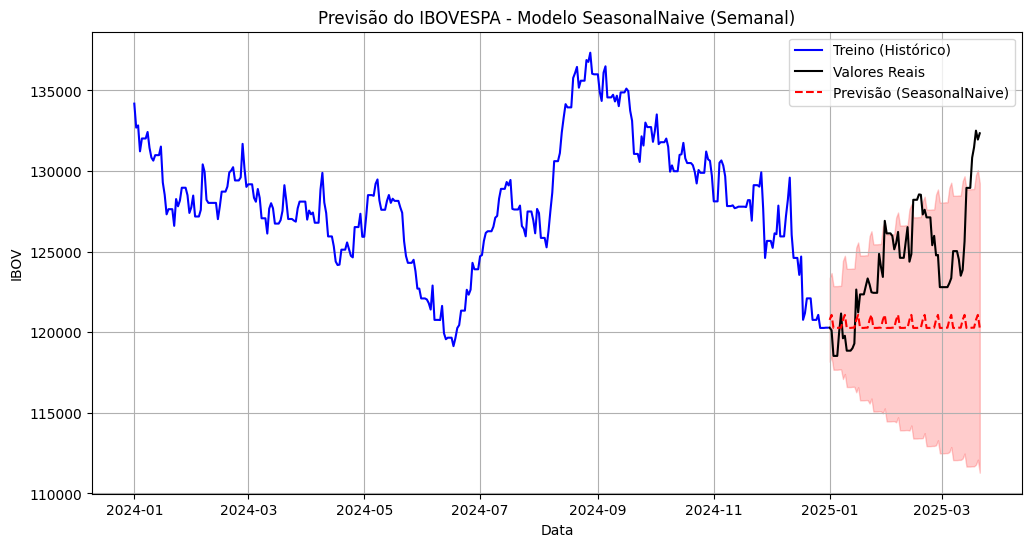

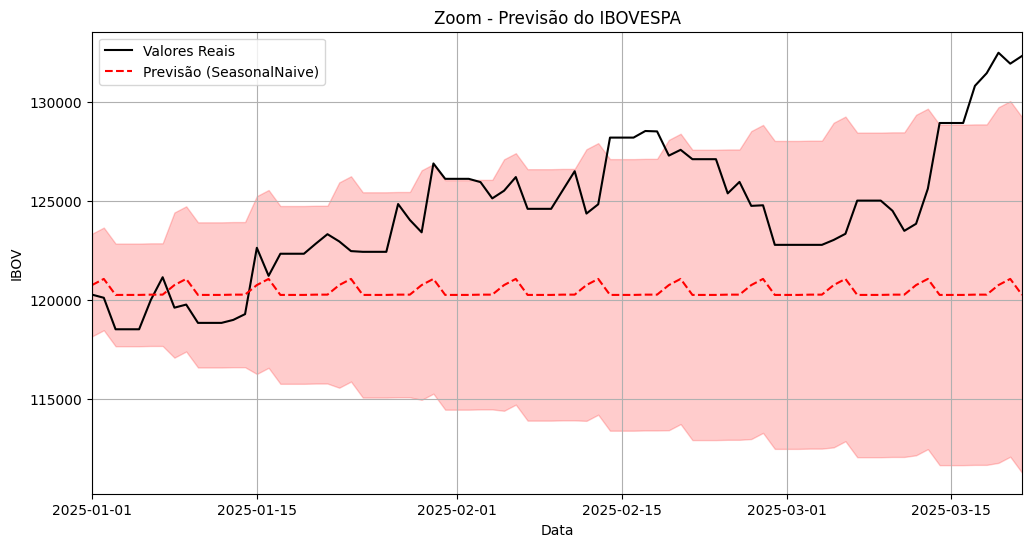

In [184]:
treino_seazonal_naive, valid_seazonal_naive, forecast_df_seazonal_naive = seazonal_naive(df_training, df_test, PERIOD_SEAZONAL_NAIVE_WEEKLY)

# Plot dos resultados
plot_forecast(treino_seazonal_naive, valid_seazonal_naive, forecast_df_seazonal_naive, "Previsão do IBOVESPA - Modelo SeasonalNaive (Semanal)")
    

### Ajuste e previsão do modelo mensal

WMAPE: 3.32%


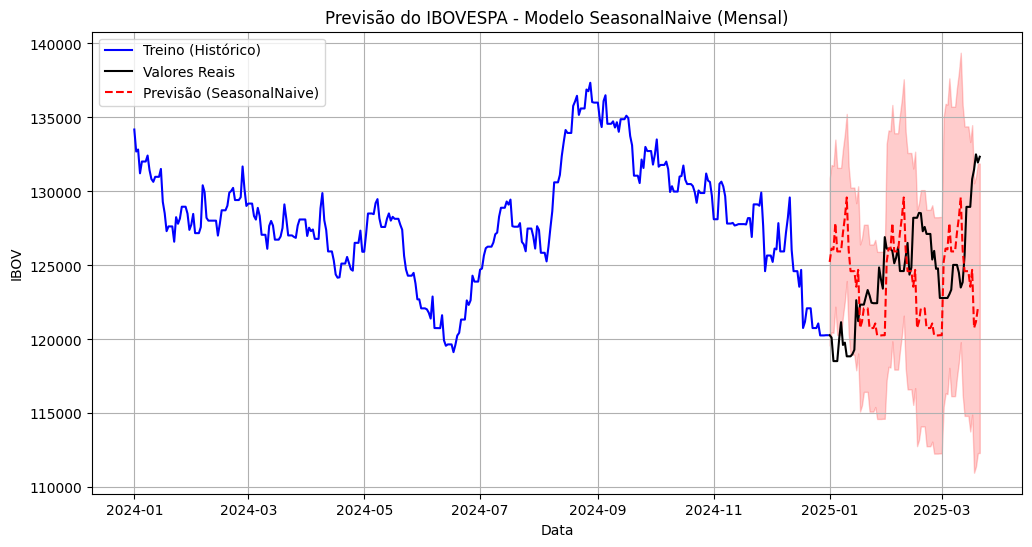

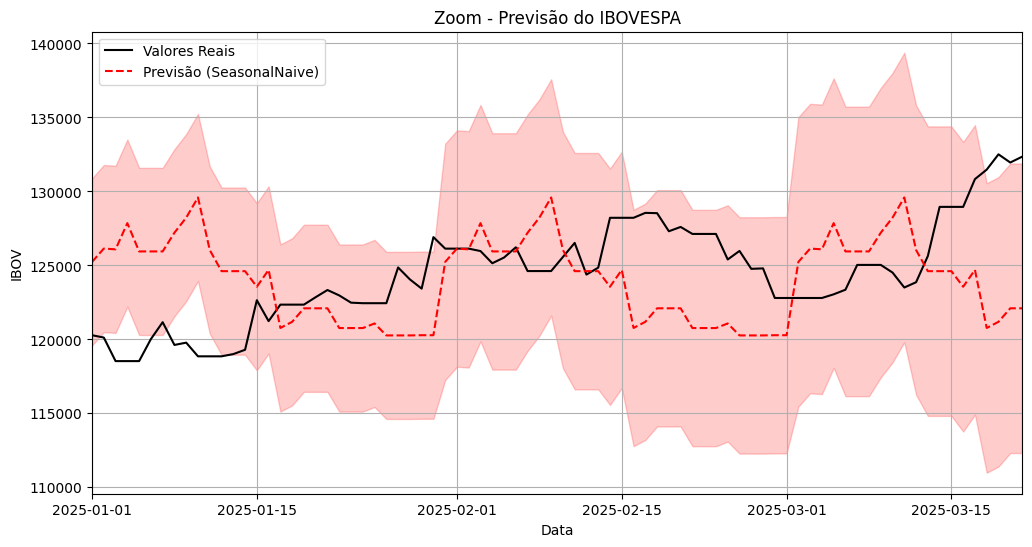

In [185]:
treino_seazonal_naive_month, valid_seazonal_naive_month, forecast_df_seazonal_naive_month = seazonal_naive(df_training, df_test, PERIOD_SEAZONAL_NAIVE_MONTHLY)

# Plot dos resultados
plot_forecast(treino_seazonal_naive_month, valid_seazonal_naive_month, forecast_df_seazonal_naive_month, "Previsão do IBOVESPA - Modelo SeasonalNaive (Mensal)")

### ARIMA

### Ajuste do modelo

In [ ]:
# Seleciona a coluna para o forecast
ts = df_training['ibov']

# Fit ARIMA model
model_naive = ARIMA(ts, order=(5, 1, 0))
model_fit = model_naive.fit()

# Forecast
forecast = model_fit.forecast(steps=PREDICTION_DAYS)

# Cria um novo index datetime
forecast_dates = pd.date_range(start=ts.index[-1], periods=PREDICTION_DAYS)
forecast_series = pd.Series(forecast.values, index=forecast_dates)

/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Previsão do Modelo

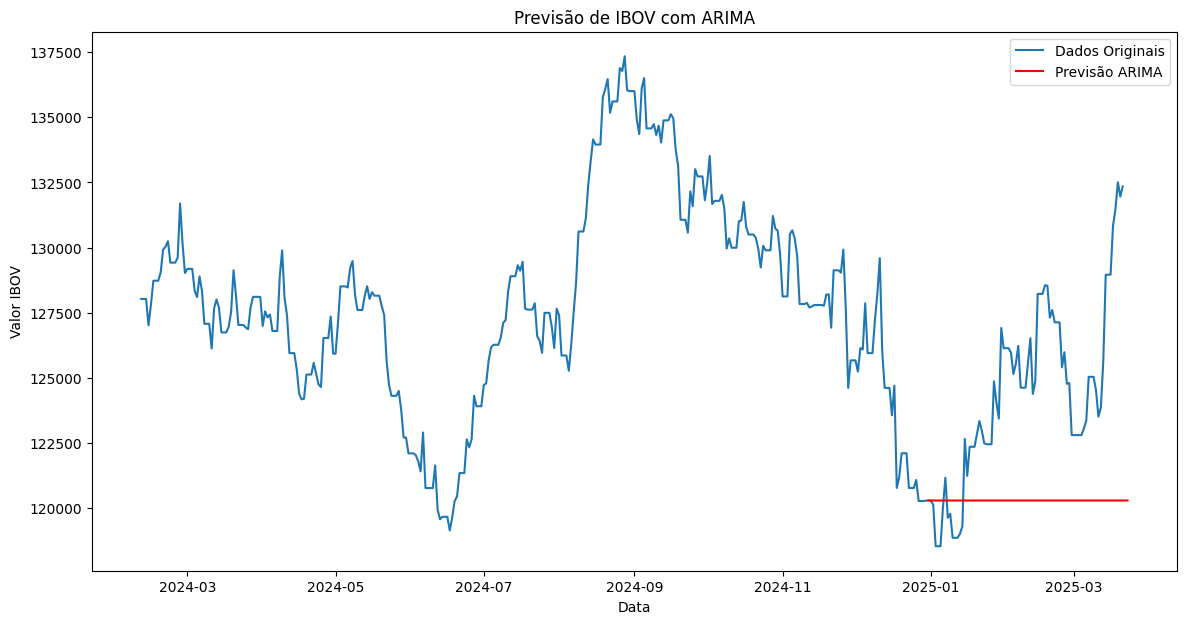

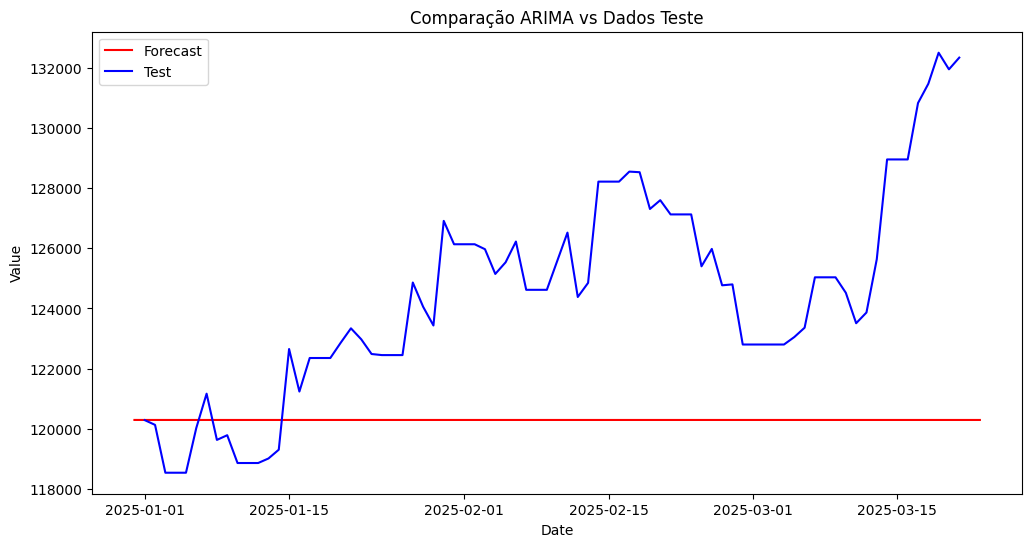

In [ ]:
# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df["ibov"].iloc[-405:], label="Dados Originais")
plt.plot(forecast_series.index, forecast_series, color="red", label="Previsão ARIMA")
plt.title("Previsão de IBOV com ARIMA")
plt.xlabel("Data")
plt.ylabel("Valor IBOV")
plt.legend()
plt.show()

# Plota comparações entre forecast_series and df_test
plt.figure(figsize=(12, 6))
plt.plot(forecast_series, label='Forecast', color='red')
plt.plot(df_test.index, df_test['ibov'], label='Test', color='blue')
plt.title('Comparação ARIMA vs Dados Teste')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### Testes de precisão do modelo ARIMA

In [188]:
# Precisão do modelo
df_forecast = pd.DataFrame({'forecast': forecast_series}).reset_index().rename(columns={'index': 'data'})

df_forecast['data'] = df_forecast['data'].apply(lambda x: x.date())

df_forecast.index = pd.to_datetime(df_forecast.data, format = '%m-%d-%Y')
df_forecast.drop('data', inplace=True, axis=1)

df_forecast = df_forecast.merge(df_test, left_index=True, right_index=True, how='right')
df_forecast['diff'] = df_forecast['ibov'] - df_forecast['forecast']
df_forecast['diff_perc'] = abs(df_forecast['ibov'] - df_forecast['forecast'])/df_forecast['ibov']
df_forecast['precision'] = 1 - df_forecast['diff_perc']

In [189]:
df_forecast['precision'].mean()

np.float64(0.9645320347383255)

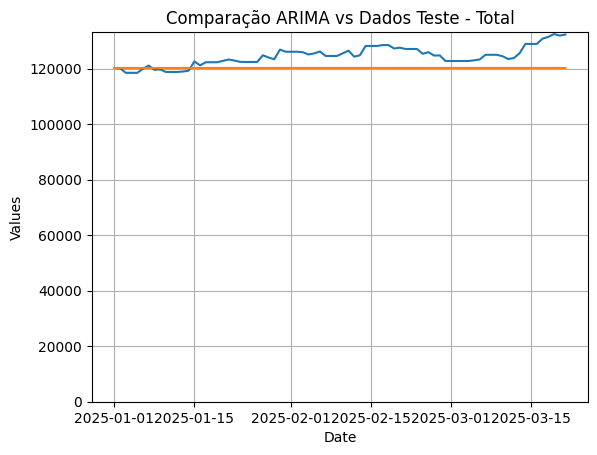

<Figure size 1200x600 with 0 Axes>

In [190]:
fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_forecast.index, df_forecast['ibov'], label='Value')
ax.plot(df_forecast.index, df_forecast['forecast'], label='Forecast')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação ARIMA vs Dados Teste - Total'
)

ax.set_ylim(ymin=0)

plt.show()

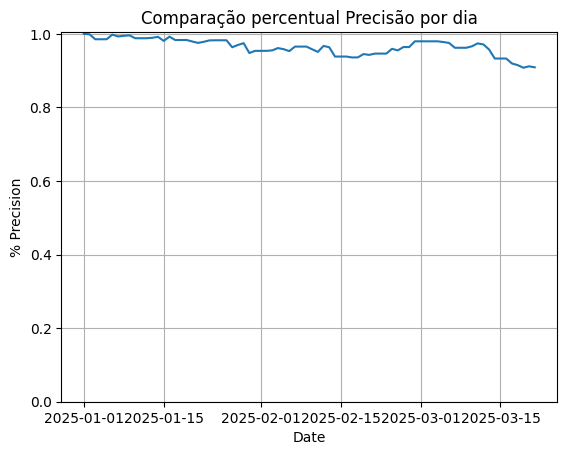

<Figure size 1200x600 with 0 Axes>

In [ ]:
df_precision = df_forecast[['precision']]

fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_precision.index, df_precision['precision'], label='a')
ax.set_ylim(ymin=0)
ax.grid()
ax.set(
    xlabel='Date',
    ylabel='% Precision',
    title='Comparação percentual Precisão por dia'
)

plt.show()

## SARIMA

### Ajuste do Modelo

In [ ]:
s = 12  # assumindo sazonaliade semanal
model_sarimax = SARIMAX(df_training['ibov'], order=(5, 1, 0), seasonal_order=(1, 1, 0, s))
resultado_sarimax = model_sarimax.fit()

# Predição com os dados de teste
sarimax_pred = resultado_sarimax.forecast(len(df_test))

# Precisão do modelo
df_forecast_sarima = pd.DataFrame({'forecast': sarimax_pred})
df_forecast_sarima = df_forecast_sarima.merge(df_test, left_index=True, right_index=True, how='left')
df_forecast_sarima['diff'] = df_forecast_sarima['ibov'] - df_forecast_sarima['forecast']
df_forecast_sarima['diff_perc'] = abs(df_forecast_sarima['ibov'] - df_forecast_sarima['forecast'])/df_forecast_sarima['ibov']
df_forecast_sarima['precision'] = 1 - df_forecast_sarima['diff_perc']

# Criando Dataframe utilizando serie Sarima
df_sarimax_pred = pd.DataFrame(
    {
        "data": sarimax_pred.index,
        "sarimax": sarimax_pred
    }
)

/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Previsão do modelo

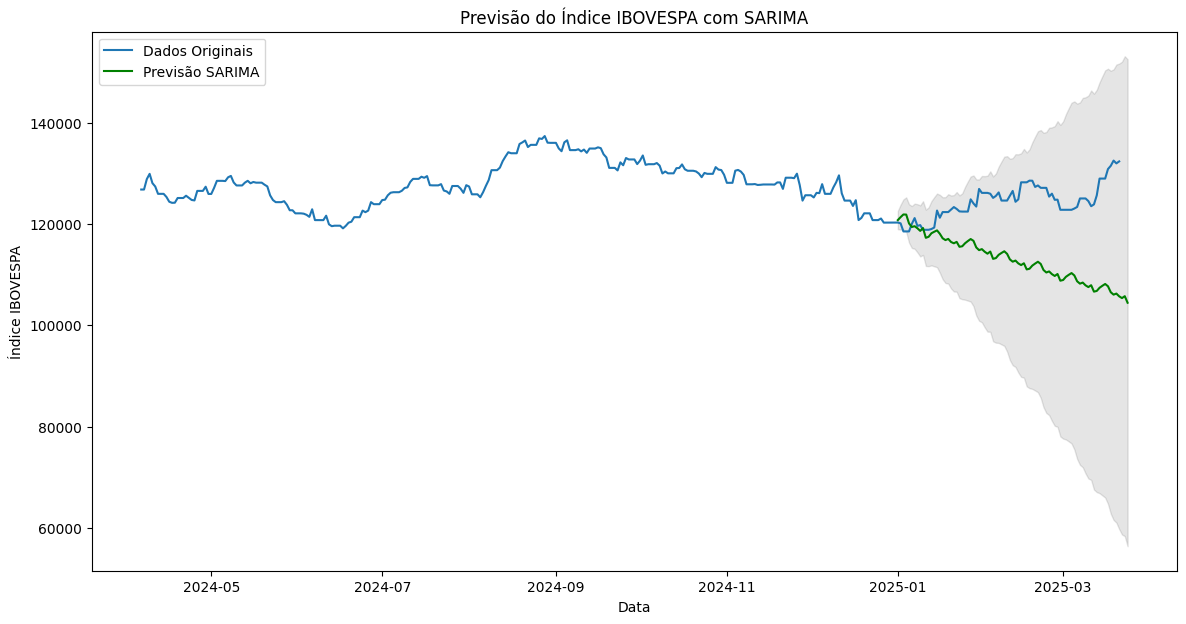

In [193]:
# Previsão dos próximos X dias (Definido pela constante PREDICTION_DAYS)
forecast_sarima = resultado_sarimax.get_forecast(steps=PREDICTION_DAYS)
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_sarima_conf_int = forecast_sarima.conf_int()

# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df["ibov"].iloc[-350:], label="Dados Originais")
plt.plot(
    forecast_sarima_mean.index,
    forecast_sarima_mean,
    color="green",
    label="Previsão SARIMA",
)
plt.fill_between(
    forecast_sarima_conf_int.index,
    forecast_sarima_conf_int.iloc[:, 0],
    forecast_sarima_conf_int.iloc[:, 1],
    color="k",
    alpha=0.1,
)
plt.title("Previsão do Índice IBOVESPA com SARIMA")
plt.xlabel("Data")
plt.ylabel("Índice IBOVESPA")
plt.legend()
plt.show()

## Comparação de resultado entre modelos

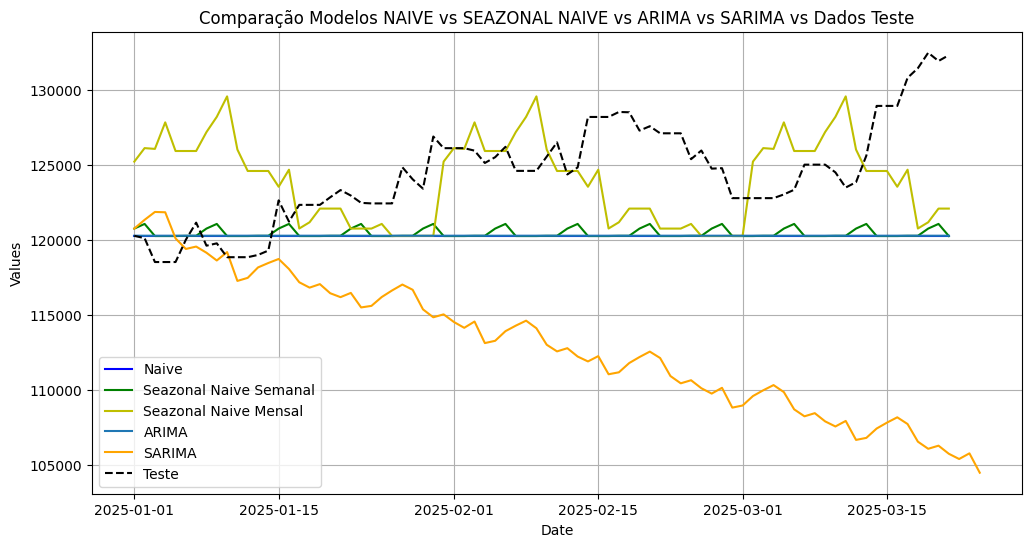

In [ ]:
# Plota a comparação entre dados do forecast_series e df_test
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(forecast_df_naive['ds'], forecast_df_naive['Naive'], label='Naive', color='blue')
ax.plot(forecast_df_seazonal_naive['ds'], forecast_df_seazonal_naive['SeasonalNaive'], label='Seazonal Naive Semanal', color='g')
ax.plot(forecast_df_seazonal_naive_month['ds'], forecast_df_seazonal_naive_month['SeasonalNaive'], label='Seazonal Naive Mensal', color='y')
ax.plot(df_forecast.index, df_forecast['forecast'], label='ARIMA')
ax.plot(forecast_sarima_mean.index, forecast_sarima_mean, label = 'SARIMA', color = 'orange')
ax.plot(df_forecast.index, df_forecast['ibov'], label='Teste', color = 'black', linestyle="dashed")

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação Modelos NAIVE vs SEAZONAL NAIVE vs ARIMA vs SARIMA vs Dados Teste'
)

ax.legend()

plt.show()

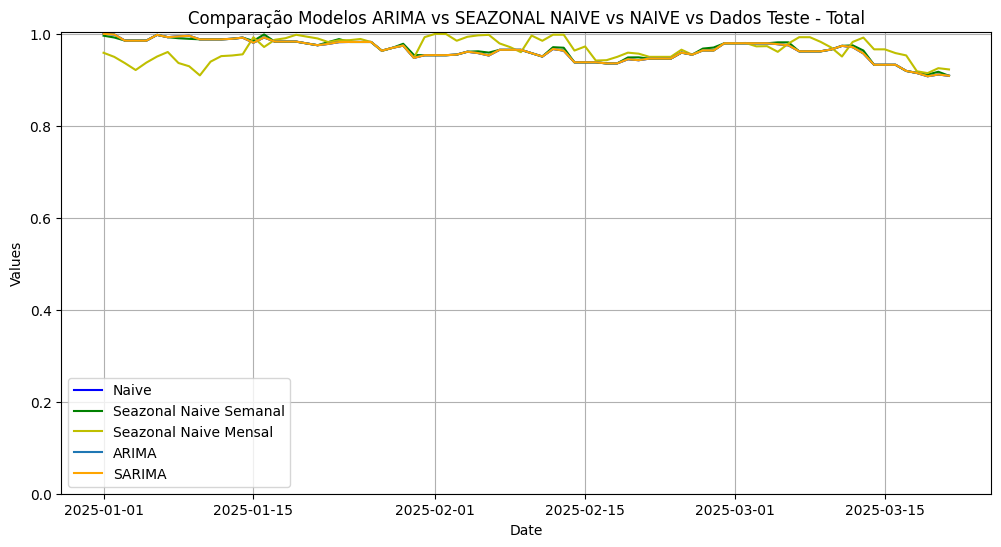

In [ ]:
# Plota a comparação entre dados de precisão do forecast_series e df_test
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(forecast_df_naive['ds'], forecast_df_naive['precision'], label='Naive', color='blue')
ax.plot(forecast_df_seazonal_naive['ds'], forecast_df_seazonal_naive['precision'], label='Seazonal Naive Semanal', color='g')
ax.plot(forecast_df_seazonal_naive_month['ds'], forecast_df_seazonal_naive_month['precision'], label='Seazonal Naive Mensal', color='y')
ax.plot(df_forecast.index, df_forecast['precision'], label='ARIMA')
ax.plot(df_forecast_sarima.index, df_forecast['precision'], label='SARIMA', color='orange')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação Modelos ARIMA vs SEAZONAL NAIVE vs NAIVE vs Dados Teste - Total'
)

ax.set_ylim(ymin=0)
ax.legend()
plt.show()

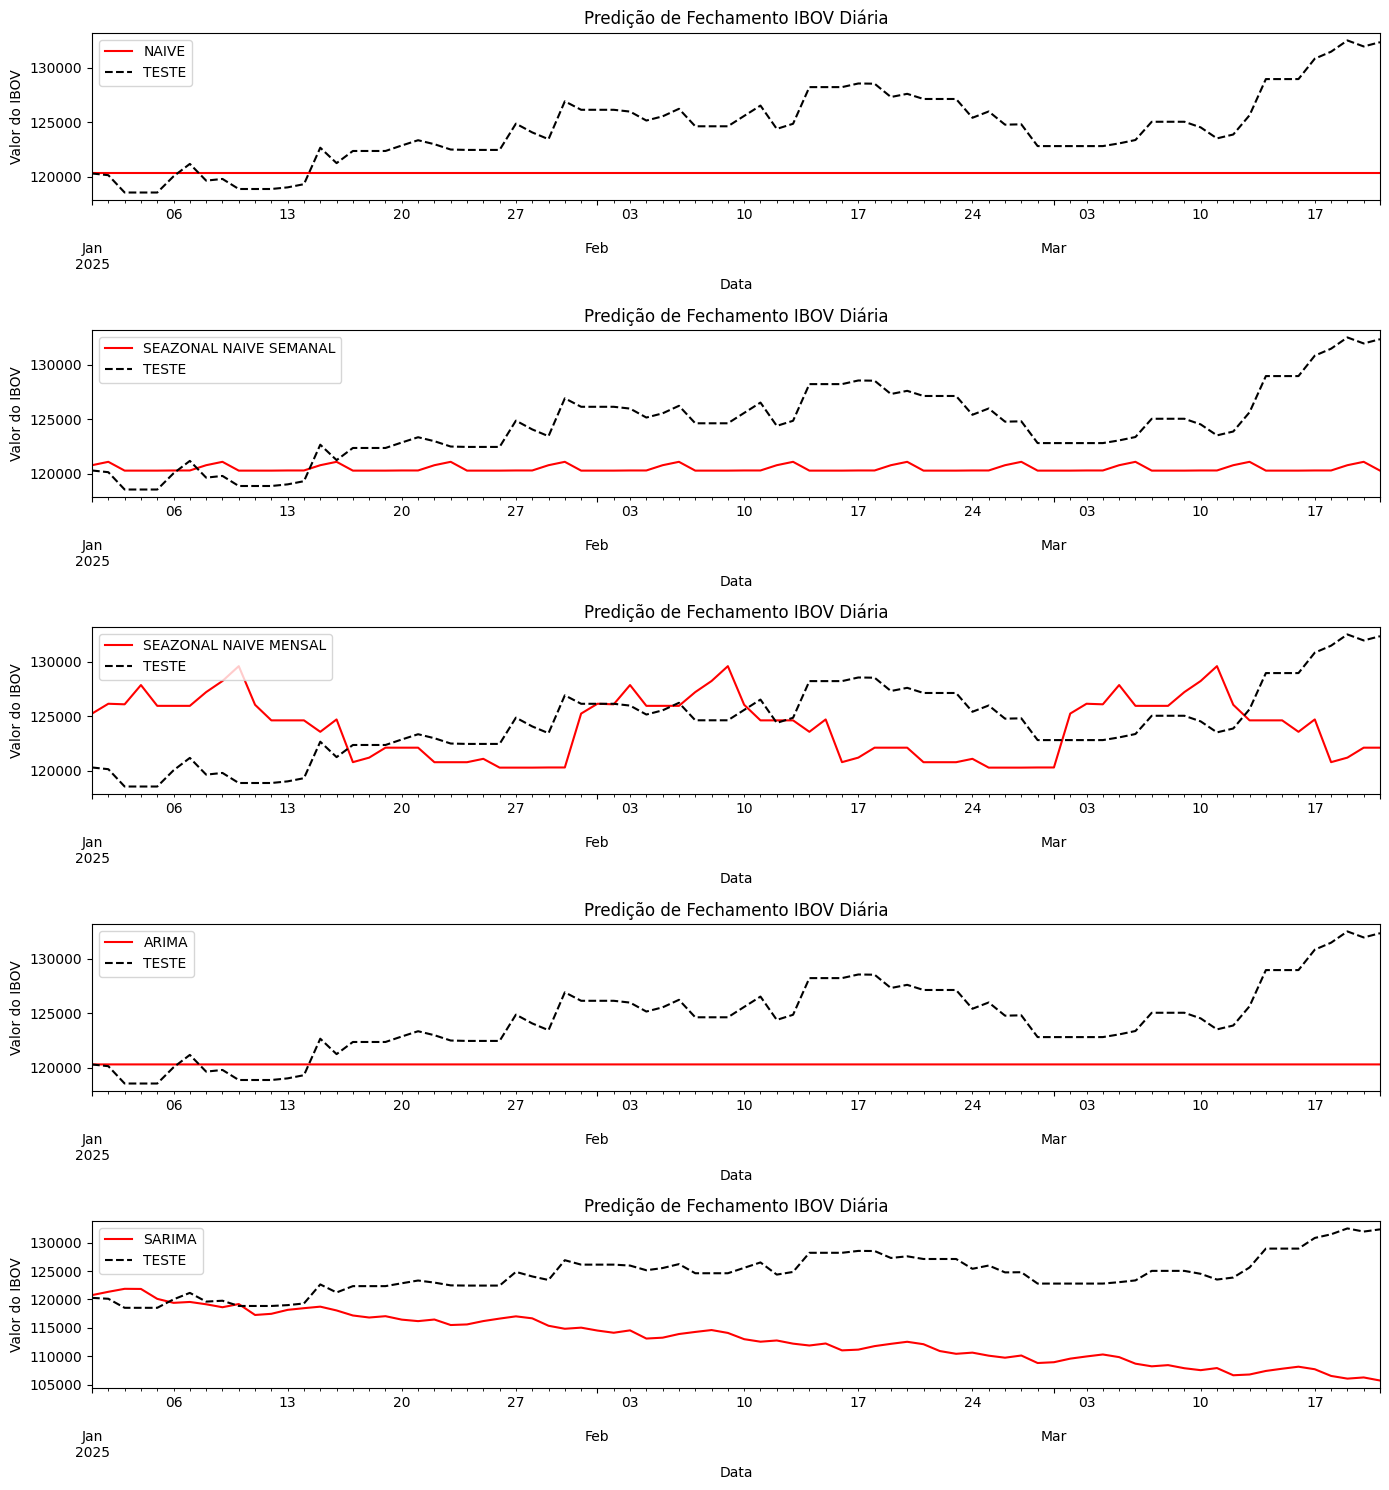

In [ ]:
# Predição de Fechamento IBOV diárias
idx = df_test.index
results = pd.DataFrame(
    {
        'NAIVE': forecast_df_naive.set_index('ds')['Naive'],
        'SEAZONAL NAIVE SEMANAL': forecast_df_seazonal_naive.set_index('ds')['SeasonalNaive'],
        'SEAZONAL NAIVE MENSAL': forecast_df_seazonal_naive_month.set_index('ds')['SeasonalNaive'],
        'ARIMA': df_forecast.forecast,
        'SARIMA': sarimax_pred,
        'TESTE': df_test['ibov'].loc[idx],
    }
)

fig, ax = plt.subplots(5, 1, figsize=(14, 15))
for i, model in enumerate(['NAIVE', 'SEAZONAL NAIVE SEMANAL', 'SEAZONAL NAIVE MENSAL', 'ARIMA', 'SARIMA']):
    
    results[model].plot(ax=ax[i], label=model, color = 'red')  
    results["TESTE"].plot(ax=ax[i], color="black", linestyle="dashed", label="TESTE")
    
    ax[i].legend()
    ax[i].set_title('Predição de Fechamento IBOV Diária')
    ax[i].set_xlabel('Data')
    ax[i].set_ylabel('Valor do IBOV')
ax[0].get_figure().set_tight_layout(True)

plt.subplots_adjust(hspace=1) 

In [198]:
def generate_precision_each_model(df_test, df_forecast, index_test, index_forecast):

    mae = mean_absolute_error(df_test[index_test], df_forecast[index_forecast])/1000
    rmse = mean_squared_error(df_test[index_test], df_forecast[index_forecast])/10**7
    mape = 100 * mean_absolute_percentage_error(
        df_test[index_test], df_forecast[index_forecast]
    )

    return mae, rmse, mape

mae_naive, rmse_naive, mape_naive = generate_precision_each_model(df_test, forecast_df_naive, 'ibov', 'Naive')
mae_seazonal_naive, rmse_seazonal_naive, mape_seazonal_naive = generate_precision_each_model(df_test, forecast_df_seazonal_naive, 'ibov', 'SeasonalNaive')
mae_seazonal_naive_month, rmse_seazonal_naive_month, mape_seazonal_naive_month = generate_precision_each_model(df_test, forecast_df_seazonal_naive_month, 'ibov', 'SeasonalNaive')
mae_arima, rmse_arima, mape_arima = generate_precision_each_model(df_test, df_forecast, 'ibov', 'forecast')
mae_sarimax, rmse_sarimax, mape_sarimax = generate_precision_each_model(df_test, df_sarimax_pred, 'ibov', 'sarimax')



### Calculando Precisão de cada Modelo

In [238]:
# gerando um dataframe com o resultado das métricas de erro para cada modelo
resultados = pd.DataFrame(
    {
        "Modelo": ["Naive", "Seazonal Naive (Semanal)", "Seasonal Naive (Mensal)", "Arima", "Sarimax"],
        "MAE": [mae_naive, mae_seazonal_naive, mae_seazonal_naive_month, mae_arima, mae_sarimax],
        "RMSE": [rmse_naive, rmse_seazonal_naive, rmse_seazonal_naive_month, rmse_arima, rmse_sarimax],
        "MAPE (%)": [mape_naive, mape_seazonal_naive, mape_seazonal_naive_month, mape_arima, mape_sarimax],
        "Accuracy (%)": [
            100 - mape for mape in [mape_naive, mape_seazonal_naive, mape_seazonal_naive_month, mape_arima, mape_sarimax]
        ],
    }
).sort_values("MAPE (%)")

resultados_sem_sarimax = resultados.where(resultados['Modelo'] != 'Sarimax').dropna(how='all')
resultados_sem_sarimax = resultados_sem_sarimax.sort_values(by='Accuracy (%)', ascending=True)

resultados

,Modelo,MAE,RMSE,MAPE (%),Accuracy (%)
2,Seasonal Naive (Mensal),4.133913,2.529870,3.318608,96.681392
1,Seazonal Naive (Semanal),4.366250,2.733856,3.451692,96.548308
3,Arima,4.486687,2.870903,3.546797,96.453203
0,Naive,4.490300,2.875353,3.549642,96.450358
4,Sarimax,11.412265,17.651235,9.042894,90.957106


<Figure size 2000x1000 with 0 Axes>

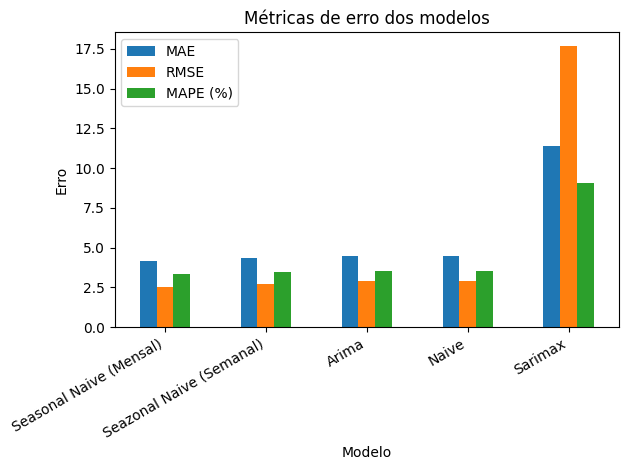

In [ ]:
plt.figure(figsize=(20,10))
ax = resultados.plot(kind='bar', y=['MAE', 'RMSE', 'MAPE (%)'], x='Modelo')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title('Métricas de erro dos modelos')
ax.set_ylabel('Erro')
ax.get_figure().set_tight_layout(True)
plt.show()

## Resultado Final Precisão dos modelos

Conforme demostrado pelo gráfico abaixo, os Modelos Naive, Arima, Seazonal Naive Semanal & Mensal tiveram precisões similares, de 96% variando 0,23% entre o maior e menor destes

Porém o Seazonal Naive Mensal obteve em valores absolutos a maior precisão: 96,68%


<Figure size 2000x1000 with 0 Axes>

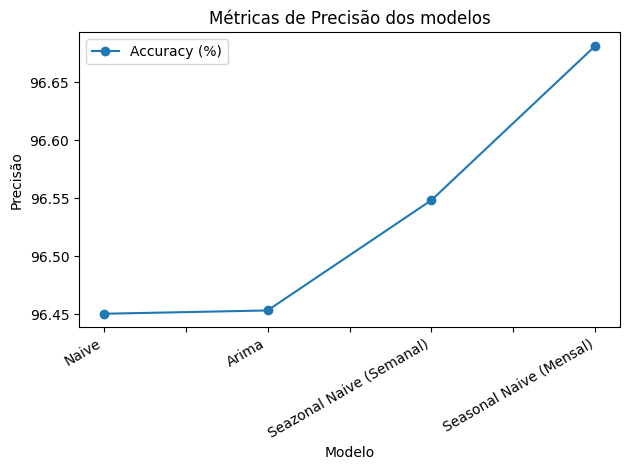

In [ ]:
plt.figure(figsize=(20,10))
ax = resultados_sem_sarimax.plot(kind='line', marker='o', y=['Accuracy (%)'], x='Modelo')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title('Métricas de Precisão dos modelos')
ax.set_ylabel('Precisão')
ax.get_figure().set_tight_layout(True)
plt.show()